In [14]:
import os
import faiss
import torch
from matplotlib import pyplot as plt
from PIL import Image
from transformers import (
    BlipProcessor,
    BlipForConditionalGeneration,
    AutoTokenizer,
    AutoModelForSeq2SeqLM
)
from sentence_transformers import SentenceTransformer

In [2]:
knowledge_img_dir = "./Images"  # contains car images
query_image_path = "Bike.jpg"  

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load models ---
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

retriever = SentenceTransformer("all-MiniLM-L6-v2")

generator_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl")
generator = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-xl").to(device)


In [16]:
knowledge_captions = []
image_paths = []

for filename in os.listdir(knowledge_img_dir):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(knowledge_img_dir, filename)
        image = Image.open(img_path).convert("RGB")
        inputs = blip_processor(images=image, return_tensors="pt").to(device)
        out = blip_model.generate(**inputs)
        caption = blip_processor.decode(out[0], skip_special_tokens=True)
        knowledge_captions.append(caption)
        image_paths.append(img_path)

print("\n*** Knowledge Captions ***")
for cap in knowledge_captions:
    print(cap)


*** Knowledge Captions ***
toyota ra sport 1 5 at
a silver car parked on a cobb street
a car with a broken hood on it
mazda ' s new cx - 5 crossover and cx - 5 crossover
a white car parked in a parking


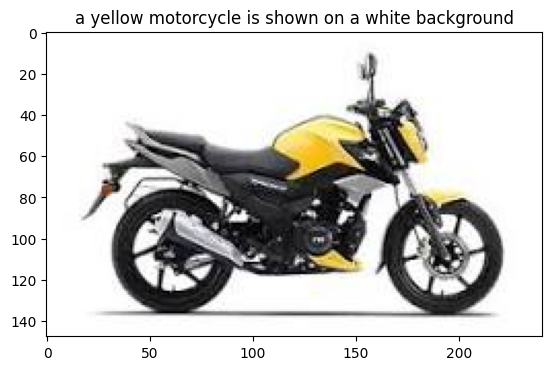

In [18]:
# Create FAISS index ---
embeddings = retriever.encode(knowledge_captions)
index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings.astype('float32'))

# Process the query image (bike) ---
query_image = Image.open(query_image_path).convert("RGB")
inputs = blip_processor(images=query_image, return_tensors="pt").to(device)
out = blip_model.generate(**inputs)
basic_caption = blip_processor.decode(out[0], skip_special_tokens=True)

plt.title(basic_caption)
plt.imshow(query_image)

In [8]:
#RAG Enhancement
query_embedding = retriever.encode([basic_caption])
scores, indices = index.search(query_embedding.astype('float32'), 3)

relevant_knowledge = []
for i, score in zip(indices[0], scores[0]):
    if score > 0.3:
        relevant_knowledge.append(knowledge_captions[i])

relevant_knowledge

['a white car parked in a parking']

In [19]:
if relevant_knowledge:
    context = " ".join(relevant_knowledge)
    prompt = (
        f"The original image caption is: '{basic_caption}'. "
        f"The following are captions of reference images: {context} "
        "Analyze the differences between the input image and the reference images. "
    )
    inputs = generator_tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
    outputs = generator.generate(inputs, max_length=100, num_beams=4)
    enhanced_caption = generator_tokenizer.decode(outputs[0], skip_special_tokens=True)
else:
    enhanced_caption = basic_caption

# --- Result ---
print("\nBasic Caption:", basic_caption)
print("Enhanced Caption:", enhanced_caption)


Basic Caption: a yellow motorcycle is shown on a white background
Enhanced Caption: The input image shows a yellow motorcycle and the reference image shows a white car.
